In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ, QuantumRegister
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *


import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt

from fractions import Fraction
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor


# Loading your IBM Q account(s)
provider = IBMQ.load_account()

In [2]:
simulator = qk.BasicAer.get_backend('qasm_simulator')
real = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits > 4,
                                            operational=True, simulator=False))
print(real)

ibmq_belem


### A Bernstein-Vazarini Probléma

Adott egy feketedoboz függvény ami egy $\underline{x} = (x_1, x_2, ..., x_n)$ bitsorhoz rendel hozzá 0-t vagy 1-et:<br><br>\begin{equation}
f(x_1, x_2, ..., x_n) = 0 \text{ or } 1.
\end{equation}
(Minden $i$-re $x_i$ 0 vagy 1.) Tudjuk, hogy a függvény minden $\underline{x}$ bitsor esetén egy $\underline{s}$ bitsorral vett bitenkénti szorzatának 2 szerinti maradékát adja vissza. A bitenkénti szorzat alatt a következő műveletet értjük: $\underline{s}\cdot\underline{x} = x_1\cdot s_1 +x_2\cdot s_2 +...+x_n\cdot s_n$. Tehát a függvényt a következő alakban írható fel: $f(\underline{x}) = \underline{s}\cdot\underline{x} \text{ mod } 2$. Az a feladat, hogy találjuk ki, hogy mi az $\underline{s}$ bitsor.<br>

![](https://github.com/gubazoltan/QBronze2023/blob/main/%C3%A1br%C3%A1k/Berstein-Vazirani-probl.png?raw=true)


### Klasszikus megoldás

**1. feladat (közösen csináljuk meg)**
Gondoljuk végig, hogy hogyan oldanánk meg A Berstein-Vazarini problémát egy klasszikus számítógéppel. Hányszor kéne ehhez elvégezni az $f$ függvényt megvalósító műveletet?

In [32]:
n = 4
s = np.random.randint(0, 2, n)

# x egy és s azonos hosszúságú numpy array-ok
# a függvény a x és s skalárszorzatának 2 szerinti maradékát adja vissza
def f(x, s): 
    if len(x) != n:
        raise ValueError("x and s have to be of the same length")
    return np.dot(x, s)%2

**2. feladat** 
Határozzuk meg a véletlenszerűen generált $s$ bitsort, anélkül, hogy kiírnánk az értékét. Használjuk az f(x, s) függvényt, ami az $\underline{s}\cdot\underline{x} \text{ mod } 2$ értéket adja vissza.

In [20]:
# megoldás helye

guess = np.zeros(n, dtype=int)
for i in range(n):
    x = np.zeros(n)
    x[i] = 1
    guess[i] = f(x, s)
print(guess, s)

[1 0 1 1] [1 0 1 1]


### Kvantumos megoldás

**Állítás**: Az alábbi ábrán látható kvantumáramkör elvégzése után pontosan az $s$ bitsort mérjük az első négy qubiten. (Az utolsó qubitet nem kell mérni, annak értéke nem érdekel minket.) Tehát elég egyszer elvégeznünk az $f$ függvényt megvalósító műveletet.

![](https://github.com/gubazoltan/QBronze2023/blob/main/%C3%A1br%C3%A1k/Berstein-Vazirani-sol.png?raw=true)

A $|-\rangle$ állapotot úgy állíthatjuk elő, hogy az $|{1}\rangle$ állapotra hatunk egy $H$ kapuval.

**Bizonyítás:** 
Nézzük meg lépésről lépésre, hogy hogyan alakul az $n+1$ qubit állapota az ábrán látható kvantumáramkör hatására:
1. A kvantumos megoldásban az első n qubit kezdeti állapota a $|0...0\rangle$ állapot (lásd ábra). Az első lépés, hogy mindegyik qubitre hat egy Hadamard kapu:
\begin{equation}
    |00...0\rangle \xrightarrow{H^{\otimes n}} \frac{1}{\sqrt{2^n}}  (|0\rangle + |1\rangle)\otimes...\otimes (|0\rangle + |1\rangle) = ?
\end{equation}
    **1. Kérdés**: Mit kapunk, ha felbontjuk a zárójeleket?
    
    **Megoldás**:
\begin{equation}
    ? = \frac{1}{\sqrt{2^n}}(|00...0\rangle + |00...1\rangle + ... + |11...1\rangle) =  \frac{1}{\sqrt{2^n}}\sum_{\underline{x}\in\{0, 1\}^n}|x\rangle 
\end{equation}

    **2. Kérdés**: Mit kapnánk, ha nem a $|00...0\rangle$ kezdeti állapotból indulnánk, hanem az $|\underline{a}\rangle = |a_1a_2...a_n\rangle$ állapotból?
    
    **Megoldás**: 
    
\begin{equation}
    |a_1a_2...a_n\rangle \xrightarrow{H^{\otimes n}} \frac{1}{\sqrt{2^n}} (|0\rangle + (-1)^{a_1}|1\rangle)\otimes...\otimes (|0\rangle + (-1)^{a_1} |1\rangle) =  \frac{1}{\sqrt{2^n}}\sum_{\underline{x}\in\{0, 1\}^n} (-1)^{\underline{a}\cdot \underline{x}} |x\rangle 
\end{equation}
    

2. Ezt követően a feketedobozt megvalósító kvantumkapu hat a qubitekre. Elevenítsük fel, hogy hogyan hat a feketedoboz a mérési bázisállapotokra:
- Ha $\underline{s}\cdot\underline{x} \text{ mod } 2 = 0$, akkor a feketedoboz nem változtatja meg az állapotot.
- Ha $\underline{s}\cdot\underline{x} \text{ mod } 2 = 1$, akkor így változik az állapot:
\begin{equation}
\begin{split}
    |x\rangle |0\rangle \xrightarrow{f_s} |x\rangle |1\rangle \\
    |x\rangle |1\rangle \xrightarrow{f_s} |x\rangle |0\rangle
\end{split}
\end{equation}

    **3. Kérdés**: Hogyan hat a feketedoboz a qubitekre, ha a bemeneti állapot az $|x\rangle|-\rangle$ állapot?
    
    **Megoldás**: 
    - Ha $\underline{s}\cdot\underline{x} \text{ mod } 2 = 0$, akkor nem változik az állapot.
    - Ha $\underline{s}\cdot\underline{x} \text{ mod } 2 = 1$, akkor:
\begin{equation}
    |x\rangle(|0\rangle- |1\rangle) \xrightarrow{f_s} |x\rangle\frac{1}{\sqrt{2}}(|1\rangle- |0\rangle) = -|x\rangle|-\rangle
\end{equation}
A két esetet így tudjuk összefoglalni:
\begin{equation}
    |x\rangle|-\rangle \xrightarrow{f_s} (-1)^{\underline{s}\cdot\underline{x}} |x\rangle|-\rangle
\end{equation}
Tehát így változik a Hadamard kapuk hatására létrejövő szuperpozíció állapot:
\begin{equation}
    \frac{1}{\sqrt{2^n}}\sum_{\underline{x}\in\{0, 1\}^n}|x\rangle|-\rangle  \xrightarrow{f_s} \frac{1}{\sqrt{2^n}}\sum_{\underline{x}\in\{0, 1\}^n}(-1)^{\underline{s}\cdot \underline{x}} |x\rangle |-\rangle
\end{equation}

3. Vegyük észre, hogy a feketedoboz utáni állapot pont ugyanaz, mintha $|s\rangle$ lenne bemeneti állapot és minden qubitre hattatnánk egy Hadamard kaput. A Hadamard kapu inverze önmaga, így a feketedoboz utáni állapototból elő tudjuk állítani az $|s\rangle$ állapotot:
\begin{equation}
    \frac{1}{\sqrt{2^n}}\sum_{\underline{x}\in\{0, 1\}^n}(-1)^{\underline{s}\cdot \underline{x}} |x\rangle |-\rangle \xrightarrow{H^{\otimes n}} |s\rangle |-\rangle
\end{equation}

Tehát tényleg az $s$ bitsztringet kapjuk eredményül, ha megmérjük az első $n$ qubitet.

In [21]:
def black_box(s): # s egy bitsor
    n = len(s)
    qc = QuantumCircuit(n+1)
    for i in range(len(s)):
        if s[n-i-1] == 1:
            qc.cx(i, n)
    qc.name = "f"
    return qc

In [47]:
"""az i egész szám bináris alakját írja be a függvény n darab qubitbe"""
def encode(i, n):
    if 2**n <= i:
        raise ValueError("'i' is too big to be stored on n qubits")
    bits = np.array(list(format(i, "b")), dtype=int)
    while len(bits) < n:
        bits = np.insert(bits, 0, 0)
    qc = QuantumCircuit(n)
    for j in range(len(bits)):
        if bits[j]  == 1:
            qc.x(n-j-1)
    qc.name = "%i" %i
    return qc

def binary(i, n): # az i egyész szám bináris alakját adja vissza egy n hosszú listában
    bits = np.array(list(format(i, "b")), dtype=int)
    while len(bits) < n:
        bits = np.insert(bits, 0, 0)
    return bits

**3. feladat (szorgalmi)** 

Ellenőrizzük, hogy a black_box(s) kvantumkapu úgy működik-e ahogy azt elvárjuk tőle az $\underline{s}=(1, 0, 1, 1)$ bitsor esetén:
- Hozzunk létre egy 5 qubites kvantumáramkört. 
- Írjunk bele egy $\underline{x}$ bitsort az első 4 qubitbe. Ehhez használhatjuk az encode($i$, $n$) függvényt, ami az $i$ egész szám bináris alakját írja bele $n$ darab qubitbe, de a függvény nélkül is könnyen megoldható a feladat. 
- Hattassuk a black_box(s) kaput az 5 qubitre, majd mérjük meg az 5. qubitet. 
- írjunk egy ciklust, ami elvégzi ezeket a lépeseket minden lehetséges 4 hosszúságú bemeneti bitsztringre. (A feladat elvégzéséhez szimulátort használjunk, ne igazi kvantumszámítógépet.)


In [50]:
s = np.array([1, 0, 1, 1])

# megoldás helye

for i in range(2**4):
    qc = QuantumCircuit(5, 1)
    qc.append(encode(i, 4), range(4))
    qc.append(black_box(s), range(5))
    qc.measure(4, 0)
    counts = execute(qc, simulator, shots=1).result().get_counts()
    print(np.dot(binary(i, n), s)%2, counts)

0 {'0': 1}
1 {'1': 1}
1 {'1': 1}
0 {'0': 1}
0 {'0': 1}
1 {'1': 1}
1 {'1': 1}
0 {'0': 1}
1 {'1': 1}
0 {'0': 1}
0 {'0': 1}
1 {'1': 1}
1 {'1': 1}
0 {'0': 1}
0 {'0': 1}
1 {'1': 1}


**4.feladat**
Rakjuk össze a fenti ábrán látható áramkört. Az $f$-el jelölt kapu helyére rakjuk a black_box($\underline{s}$) kaput. Legyen $\underline{s} = (1, 0, 1, 1)$.
Ellenőrizzük, hogy a kvantumáramkör mérésekor tényleg visszakapjuk-e az $s$ bitsort. (Az áramkört futtathatjuk $\underline{s}$ más értékeire is.) Először szimulátoron futtassuk a kvantumáramkört. Ha megfelelően műköik, akkor kipróbálhatjuk igazi kvantumszámítógépen is. A kvantumszámítógépen futtassuk többször is az áramkört (pl. shots=100), és mért eredményekből csináljunk hisztogrammot.

In [28]:
s = np.array([1, 0, 1, 1])


# megoldás helye

qc = QuantumCircuit(5, 4)
qc.x(4)
qc.h(list(range(5)))
qc.append(black_box(s), range(5))
qc.h(list(range(4)))
qc.measure(range(4), range(4))
job = execute(qc, real, shots=100)
job_monitor(job)
counts = job.result().get_counts()
print(counts)
qc.draw()

Job Status: job has successfully run
{'0000': 3, '0001': 4, '0010': 1, '0011': 14, '1000': 1, '1001': 3, '1010': 6, '1011': 68}


┌───┐     ┌────┐┌───┐┌─┐         
q_0: ┤ H ├─────┤0   ├┤ H ├┤M├─────────
     ├───┤     │    │├───┤└╥┘┌─┐      
q_1: ┤ H ├─────┤1   ├┤ H ├─╫─┤M├──────
     ├───┤     │    │├───┤ ║ └╥┘┌─┐   
q_2: ┤ H ├─────┤2 f ├┤ H ├─╫──╫─┤M├───
     ├───┤     │    │├───┤ ║  ║ └╥┘┌─┐
q_3: ┤ H ├─────┤3   ├┤ H ├─╫──╫──╫─┤M├
     ├───┤┌───┐│    │└───┘ ║  ║  ║ └╥┘
q_4: ┤ X ├┤ H ├┤4   ├──────╫──╫──╫──╫─
     └───┘└───┘└────┘      ║  ║  ║  ║ 
c: 4/══════════════════════╩══╩══╩══╩═
                           0  1  2  3

<BarContainer object of 8 artists>

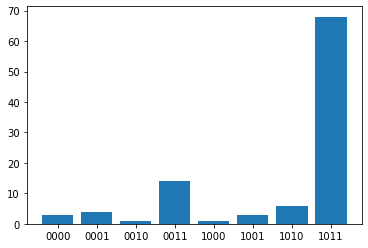

In [29]:
plt.bar(counts.keys(), counts.values())